In [81]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import sys
sys.path.append('..')
from data_utils import get_nth_episode_info
from IPython.display import clear_output
from sapien.core import Pose
from mani_skill2.envs.pick_and_place.base_env import StationaryManipulationEnv
from mani_skill2.utils.registration import register_env
import gymnasium as gym
import sapien.core as sapien
from mani_skill2 import ASSET_DIR
from pathlib import Path
from typing import Dict, List
from mani_skill2 import format_path
from mani_skill2.utils.io_utils import load_json
import numpy as np
from sapien.core import Pose
import matplotlib.pyplot as plt
from glob import glob
import time

# Register ManiSkill2 environments in gym
import mani_skill2.envs
from mani_skill2 import ASSET_DIR
from mani_skill2.utils.sapien_utils import look_at


from mani_skill2.utils.registration import register_env

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.envs.pick_and_place.stack_cube import StackCubeEnv
from mani_skill2.envs.pick_and_place.pick_single import PickSingleYCBEnv
from mani_skill2.envs.pick_and_place.pick_clutter import PickClutterYCBEnv
from mani_skill2.envs.assembly.peg_insertion_side import PegInsertionSideEnv
from mani_skill2.envs.assembly.plug_charger import PlugChargerEnv
from mani_skill2.envs.assembly.assembling_kits import AssemblingKitsEnv
from mani_skill2.envs.misc.turn_faucet import TurnFaucetEnv
from mani_skill2.envs.ms1.push_chair import PushChairEnv
from mani_skill2.envs.ms1.open_cabinet_door_drawer import OpenCabinetDoorEnv, OpenCabinetDrawerEnv
from mani_skill2.envs.ms1.move_bucket import MoveBucketEnv

from mani_skill2.utils.sapien_utils import hex2rgba
from mani_skill2.sensors.camera import CameraConfig

from transforms3d.euler import euler2quat, quat2euler
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
import itertools

from PIL import Image
from tqdm import trange

In [82]:
def register_two_objects(size_1, color_1, size_2, color_2):
    @register_env("CustomEnv-v0", max_episode_steps=200, override=True)
    class CustomEnv(PickCubeEnv):
        def _load_actors(self):
            self._add_ground(render=self.bg_name is None)
            self.obj = self._build_cube(self.cube_half_size*size_1, color=color_1, static=True)
            self.obj2 = self._build_cube(self.cube_half_size*size_2, color=color_2, static=True)
            self.goal_site = self._build_sphere_site(self.goal_thresh)

        def _register_cameras(self):
            pose = look_at([-1, 0, 1], [0, 0, 0])
            return CameraConfig(
                "base_camera", pose.p, pose.q, 512, 512, np.pi/3, 0.01, 10
            )

In [107]:
size = 1
model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))

@register_env("CustomEnv-v0", max_episode_steps=200, override=True)
class CustomEnv(PickCubeEnv):
    def _load_actors(self):
        self._add_ground(render=self.bg_name is None)

        scale = self.cube_half_size / 0.01887479572529618 * size
        
        objs = []
        for i, model in enumerate(model_paths):
            obj = build_asset(self, model, scale)
            if i == 0:
                self.obj = obj
            else:
                setattr(self, f"obj{i}", obj)
            objs.append(obj)
        self.objs = objs
        self.goal_site = self._build_sphere_site(self.goal_thresh)

    def _register_cameras(self):
        pose = look_at([-2, 0, 1], [0, 0, 0])
        return CameraConfig(
            "base_camera", pose.p, pose.q, 512, 512, np.pi/3, 0.01, 10
        )

def build_asset(self, filepath, scale):
    model_dir = Path(filepath).resolve()
    # model_dir = ".." / ASSET_DIR / "mani_skill2_ycb/models/011_banana"
    builder = self._scene.create_actor_builder()

    collision_file = str(model_dir / "collision.obj")
    builder.add_multiple_collisions_from_file(
        filename=collision_file, scale=scale, density=1000
    )
    visual_file = str(model_dir / "textured.obj")
    builder.add_visual_from_file(filename=visual_file, scale=scale)
    # builder.add_box_visual()
    # obj = builder.build_static(name=filepath.split("/")[-1], )
    obj = builder.build(name=filepath.split("/")[-1])
    obj.lock_motion(False, False, False, True, True, True)
    return obj

# env = gym.make("CustomEnv-v0", obs_mode="rgbd")
# _ = env.reset()


# obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
# plt.imshow(obs['image']['base_camera']['rgb'])

2024-03-12 14:04:32,056 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


In [108]:
def is_overlapping(pos1, pos2, min_dist):
    # Calculate the Euclidean distance between two positions
    dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    return dist < min_dist

def generate_non_overlapping_position(existing_positions, min_dist, low=-0.5, high=0.5):
    while True:
        # Generate a random position
        new_position = np.random.uniform(low=low, high=high, size=(2))
        # Check for overlap with existing positions
        overlap = any(is_overlapping(new_position, pos, min_dist) for pos in existing_positions)
        if not overlap:
            return new_position


def initalize_one_cube(obj, size, low=-0.5, high=0.5):
    position = np.random.uniform(low=low, high=high, size=(2))
    obj.set_pose(Pose([position[0], position[1], env.cube_half_size[-1]*size*2+1], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

def initalize_two_cubes(obj1, obj2, size_1, size_2):
    existing_positions = []
    # min_dist = 2 * 4 * np.sqrt(2) * env.cube_half_size[-1]
    min_dist = (sizes[0] + sizes[1]) * np.sqrt(2) * env.cube_half_size[-1]
    position = generate_non_overlapping_position(existing_positions, min_dist)
    obj1.set_pose(Pose([position[0], position[1], 0.25], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))
    existing_positions.append(position)
    position = generate_non_overlapping_position(existing_positions, min_dist)
    # obj2.set_pose(Pose([position[0], position[1], env.cube_half_size[-1]*size_2], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))
    obj2.set_pose(Pose([position[0], position[1], 0.25], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

def place_cubes_in_direction(env, obj1, obj2, direction, size_1, size_2):
    distance = env.cube_half_size[-1]*(size_1 + size_2) * np.sqrt(2)

    pose_obj2 = obj2.get_pose()
    if direction == "front":
        new_position_obj1 = [pose_obj2.p[0] - distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "behind":
        new_position_obj1 = [pose_obj2.p[0] + distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "right":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] - distance, pose_obj2.p[2]]
    elif direction == "left":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] + distance, pose_obj2.p[2]]
    elif direction == "top":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1], pose_obj2.p[2] + env.cube_half_size[-1]*(size_1 + size_2)]
        
    obj1.set_pose(Pose(new_position_obj1, obj1.get_pose().q))

# import os
# data_dir = "final_data/one_object"
# initial_dir = f"{data_dir}/initial"
# for c in range(9): # for each color
#     os.makedirs(f"{initial_dir}/{c}", exist_ok=True)
# final_dir = f"{data_dir}/final"
# for c in range(9): # for each color
#     os.makedirs(f"{final_dir}/{c}", exist_ok=True)


# data_dir = "final_data/two_objects"
# initial_dir = f"{data_dir}/initial"
# for c in range(72): # for each color pair
#     os.makedirs(f"{initial_dir}/{c}", exist_ok=True)
# final_dir = f"{data_dir}/final"
# for c in range(72): # for each color pair
#     os.makedirs(f"{final_dir}/{c}", exist_ok=True)


# color_maps = {
#     "red": (1, 0, 0),
#     "blue": (0, 0, 1),
#     "green": (0, 1, 0),
#     "white": (1, 1, 1),
#     "black": (0, 0, 0),
#     "yellow": (1, 1, 0),
#     "orange": (1, 0.5, 0),
#     "purple": (0.5, 0, 0.5),
#     "gray": (0.5, 0.5, 0.5),
# }
# directions = ["front", "behind", "right", "left", "top"]
# def save_img(filename):
#     obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
#     Image.fromarray((obs['image']['base_camera']['rgb']).astype(np.uint8)).save(f"{filename}.png")

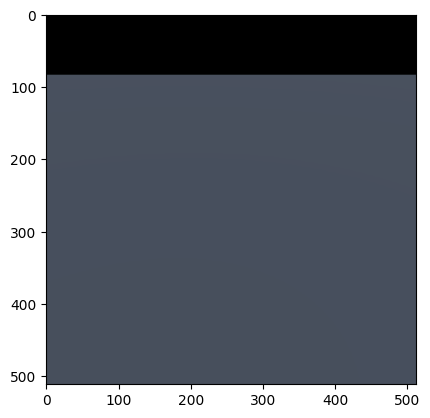

In [109]:
env = gym.make("CustomEnv-v0", obs_mode="rgbd")
env.reset()

# move robot arm away
env.get_articulations()[0].set_pose(Pose([3, 3, 4], [1, 0, 0, 0]))

# sizes = np.random.uniform(2.5, 5, 2)
# size_1, size_2 = sizes
# initalize_two_cubes(env.obj, env.obj1, size_1, size_2)
# # env.obj.set_pose(Pose([0, 0, env.cube_half_size[-1]*size*2], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

# # initalize_one_cube(env.obj, size_1)

# # # force = [10, 0, 0]
# # env.obj.add_force(force)
# # time_step = 1/60  # 60 FPS

# obj_pose = env.obj.get_pose()
# obj_pose.p[1] *= -1

for _ in range(1):  # Simulate for 1 second
    # env.obj.add_force_at_point(np.array([0, 0 , 1000]), np.array([0, 0, 0]))
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)

# obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.show()
    time.sleep(0.1)

In [110]:
obj_pose = env.obj.get_pose()
obj_pose.p[2] += 10

env.obj.add_force_at_point(np.array([0, 0 , 10000]), np.array([0, 0, 0]))

for _ in range(15):  # Simulate for 1 second
    # env.obj.add_force_at_point(np.array([0, 2500 , 0]), np.array([0, 0, 0]))
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)

    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.show()
    time.sleep(0.1)

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(


KeyboardInterrupt: 

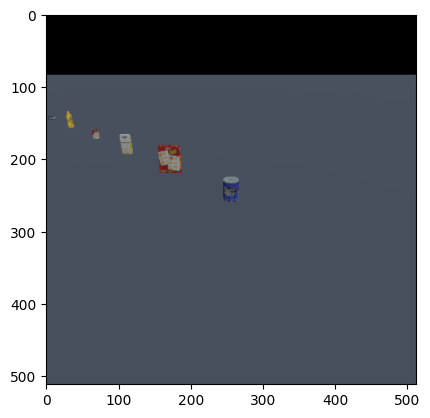

In [111]:
env = gym.make("CustomEnv-v0", obs_mode="rgbd")
env.reset()

# move robot arm away
env.get_articulations()[0].set_pose(Pose([3, 3, 2], [1, 0, 0, 0]))

for i in range(len(env.objs)):
    pose = env.objs[i].get_pose()
    pose = Pose([i*0.5, i*0.5, 1], pose.q)
    env.objs[i].set_pose(pose)


# sizes = np.random.uniform(2.5, 5, 2)
# size_1, size_2 = sizes
# initalize_two_cubes(env.obj, env.obj1, size_1, size_2)
# # env.obj.set_pose(Pose([0, 0, env.cube_half_size[-1]*size*2], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

# # initalize_one_cube(env.obj, size_1)

# # # force = [10, 0, 0]
# # env.obj.add_force(force)
# # time_step = 1/60  # 60 FPS

# obj_pose = env.obj.get_pose()
# obj_pose.p[1] *= -1

for _ in range(10):  # Simulate for 1 second
    # env.obj.add_force_at_point(np.array([0, 0 , 1000]), np.array([0, 0, 0]))
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)

# obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.show()
    time.sleep(0.1)

In [250]:
# initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 2))

# 72 color pairs
for color_idx in trange(len(pairs)):
    color_1, color_2 = pairs[color_idx]
    for r in trange(20):
        sizes = np.random.uniform(2.5, 5, 2)
        size_1, size_2 = sizes
        register_two_objects(size_1, color_maps[color_1], size_2, color_maps[color_2])

        env = gym.make("CustomEnv-v0", obs_mode="rgbd")
        _ = env.reset()

        initalize_two_cubes(env.obj, env.obj2, size_1, size_2)

        save_img(f"{initial_dir}/{color_idx}/{r}")
        for i, direction in enumerate(directions):
            place_cubes_in_direction(env, env.obj, env.obj2, direction, size_1, size_2)
            save_dir = f"{final_dir}/{color_idx}/{r}_{color_1}_{direction}_{color_2}"
            save_img(save_dir)

  0%|          | 0/72 [00:00<?, ?it/s]2024-03-08 18:43:52,843 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 18:43:52.844] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
2024-03-08 18:43:53,087 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 18:43:53.087] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
2024-03-08 18:43:53,322 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 18:43:53.322] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
2024-03-08 18:43:53,556 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 18:43:53.556] [svulkan2] [warning] A second renderer will share the same internal context

In [ ]:
## Data folder
data_folder = "data"

### One object
"data/one_object/initial_img/0~9/0~20" # 180
    "color_idx_rand_idx"
    "0/0"
    "0/19"
    "1_0"
"data/one_object/final_img/0~8" # 9 * 20 * 5
    "{init_color}_{rand_idx}_{direction}"
    "0/0_left"
    "0/0_right"
    "0/0_front"
    "1/0_front"
    "1/20_front"


### two objects
"data/two_objects/initial_img/0~72/0~20"
    "data/two_objects/initial_img/color_idx/rand_idx"
"data/two_objects/final_img/0~72"
    "{init_color_idx}_{init_rand_idx}_{color_1}_{direction}_{color2}"
    "0/0_red_left_blue"
    "0/1_red_left_blue"
    "0/20_red_left_blue"
    "0/0_red_right_blue"
    

In [370]:
import os
data_dir = "final_data/one_object"
initial_dir = f"{data_dir}/initial"
for c in range(9): # for each color
    os.makedirs(f"{initial_dir}/{c}", exist_ok=True)
final_dir = f"{data_dir}/final"
for c in range(9): # for each color
    os.makedirs(f"{final_dir}/{c}", exist_ok=True)
directions = ["forward", "backward", "right", "left"]


# 1 object
def register_one_object(size_1, color_1):
    @register_env("CustomEnv-v0", max_episode_steps=200, override=True)
    class CustomEnv(PickCubeEnv):
        def _load_actors(self):
            self._add_ground(render=self.bg_name is None)
            self.obj = self._build_cube(self.cube_half_size*size_1, color=color_1, static=True)
            self.goal_site = self._build_sphere_site(self.goal_thresh)

        def _register_cameras(self):
            pose = look_at([-1, 0, 1], [0, 0, 0])
            return CameraConfig(
                "base_camera", pose.p, pose.q, 512, 512, np.pi/3, 0.01, 10
            )

def initalize_one_cube(obj, size, low=-0.5, high=0.5):
    position = np.random.uniform(low=low, high=high, size=(2))
    obj.set_pose(Pose([position[0], position[1], env.cube_half_size[-1]*size*2], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

def place_cube_in_direction(env, obj, direction, size):
    distance = env.cube_half_size[-1]*size*4

    pose_obj = obj.get_pose()
    if direction == "forward":
        new_position_obj = [pose_obj.p[0] - distance, pose_obj.p[1], pose_obj.p[2]]
    elif direction == "backward":
        new_position_obj = [pose_obj.p[0] + distance, pose_obj.p[1], pose_obj.p[2]]
    elif direction == "right":
        new_position_obj = [pose_obj.p[0], pose_obj.p[1] - distance, pose_obj.p[2]]
    elif direction == "left":
        new_position_obj = [pose_obj.p[0], pose_obj.p[1] + distance, pose_obj.p[2]]

    obj.set_pose(Pose(new_position_obj, obj.get_pose().q))

In [372]:
# 72 color pairs
for color_idx, color_name in enumerate(list(color_maps.keys())):
    color = color_maps[color_name]

    for r in trange(20):
        size = np.random.uniform(3, 5)
        register_one_object(size, color)

        env = gym.make("CustomEnv-v0", obs_mode="rgbd")
        _ = env.reset()

        initalize_one_cube(env.obj, size)

        save_img(f"{initial_dir}/{color_idx}/{r}")
        for i, direction in enumerate(directions):
            place_cube_in_direction(env, env.obj, direction, size)
            save_dir = f"{final_dir}/{color_idx}/{r}_{direction}"
            save_img(save_dir)

  0%|          | 0/20 [00:00<?, ?it/s]2024-03-08 19:36:05,924 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 19:36:05.924] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cube_half_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cube_half_size` for environment variables or `env.get_wrapper_attr('cube_half_size')` that will

2024-03-08 19:31:19,392 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-08 19:31:19.393] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


(0.0, 1.0, 0.0, 1.0)

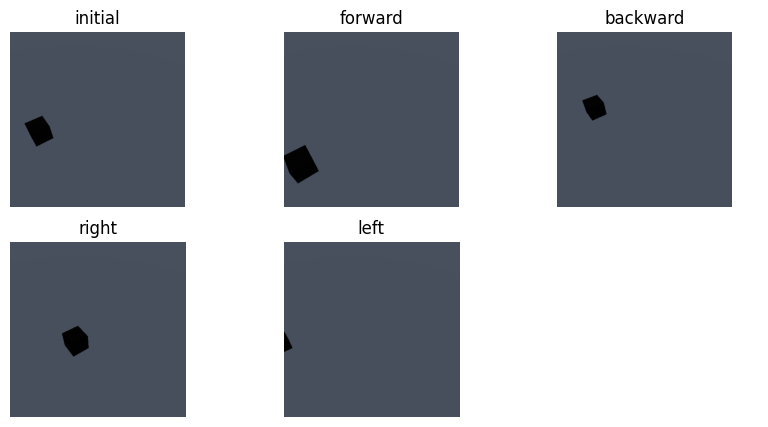

In [366]:
size = np.random.uniform(3, 5)
register_one_object(size, color_maps[np.random.choice(list(color_maps.keys()))])

env = gym.make("CustomEnv-v0", obs_mode="rgbd")
_ = env.reset()
initalize_one_cube(env.obj, size)


fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.flatten()
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])
axs[0].set_title("initial")
axs[0].axis("off")

original_pose = env.obj.get_pose()

# move obj1 to obj2
for i, direction in enumerate(directions):
    env.obj.set_pose(original_pose)
    place_cube_in_direction(env, env.obj, direction, size)
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    axs[i+1].imshow(obs['image']['base_camera']['rgb'])
    axs[i+1].set_title(direction)
    axs[i+1].axis("off")
axs[-1].axis('off')

[2024-03-08 17:37:43.340] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


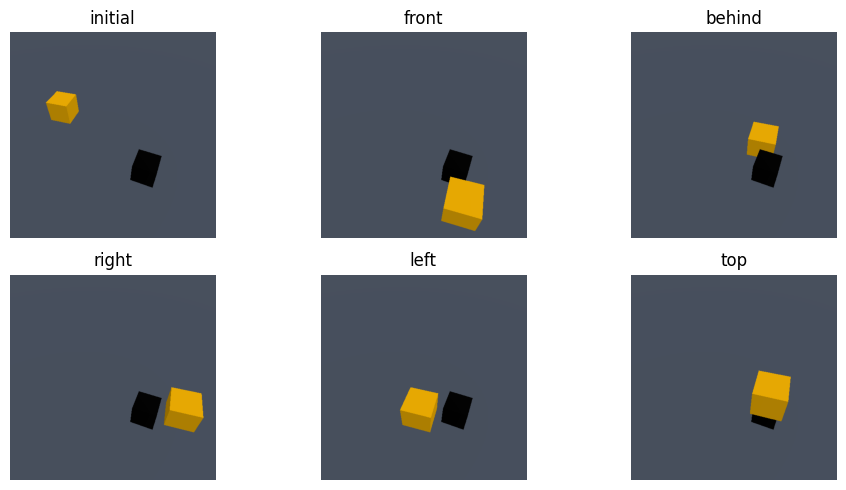

In [182]:
# 2 objects
# - move one object on front / behind / right / left top.
env = gym.make("CustomEnv-v0", obs_mode="rgbd")
_ = env.reset()

seed = None
obs, _ = env.reset(seed=seed)
np.random.seed(seed)

initalize_two_cubes(env.obj, env.obj2, size_1, size_2)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.flatten()
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])
axs[0].set_title("initial")
axs[0].axis("off")

# move obj1 to obj2
for i, direction in enumerate(["front", "behind", "right", "left", "top"]):
    place_in_direction(env, env.obj, env.obj2, env.cube_half_size[-1]*8*np.sqrt(2), direction, size_2)
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    axs[i+1].imshow(obs['image']['base_camera']['rgb'])
    axs[i+1].set_title(direction)
    axs[i+1].axis("off")

plt.tight_layout()
plt.show()

In [1]:
# adding YCB objects

2024-03-12 01:23:13,396 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-12 01:23:13.493] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


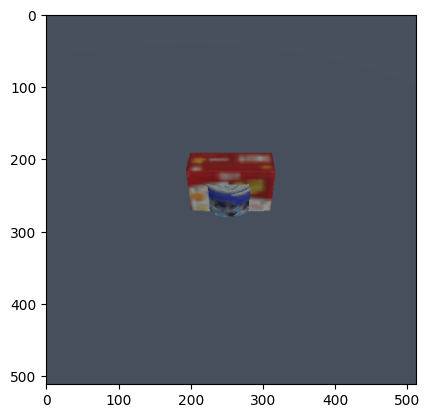